In [1]:
import os
import re
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models,transforms,datasets
from tqdm import tqdm
from tqdm import tqdm_notebook
# import scikit-learn as sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.model_selection import KFold
import itertools

/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_7311/2580507176.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Use available device

In [2]:
device = "cpu"
if torch.cuda.is_available():
    print("using gpu")
    device = torch.device("gpu")
elif torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("mps")

using mps


## Data loader

In [3]:
resized_images = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [4]:
data_dir = '../Data/brain_tumor/brain_tumor_dataset/'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=resized_images) for x in ['train', 'test']}

In [5]:
train_loader = torch.utils.data.DataLoader(dsets['train'], batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=8, shuffle=False, num_workers=2)

In [6]:
# Test the data loader
# for image, label in test_loader:
#     print(image)
#     print(label)

## Train/test functions

In [7]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1,verbose=True):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs): #tqdm(range(n_epochs)):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        if verbose:
            print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

In [8]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        bs = labels.size(0)

        output = model.forward(inputs)
        loss = loss_fn(output, labels)

        pred = output.max(1, keepdim=True)[1]
        running_loss += loss
        running_corrects += pred.eq(labels.view_as(pred)).sum()

        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [9]:
def train_and_test(model,data_loader_train, data_loader_test,loss_fn,optimizer,n_epochs=1):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    loss_test = np.zeros(n_epochs)
    acc_test = np.zeros(n_epochs)
    
    for epoch_num in tqdm(range(n_epochs)):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_train:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_test:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)

            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()

            size += bs

        print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))
        loss_test[epoch_num] = running_loss / size
        acc_test[epoch_num] = running_corrects.item() / size
        
    return loss_train, acc_train, loss_test, acc_test

In [10]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    labels_all = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    
    return labels_all, predictions

In [11]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (4, 4))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [12]:
def evaluation_plots(model, test_loader, loss_train, acc_train, loss_test, acc_test):
    plt.plot(np.arange(1,len(loss_train)+1), loss_train, label='Loss train')
    plt.plot(np.arange(1,len(loss_test)+1), loss_test, label='Loss test')
    plt.legend()
    plt.title('Loss according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(np.arange(1,len(loss_train)+1), np.log(loss_train), label='Loss train')
    plt.plot(np.arange(1,len(loss_test)+1), np.log(loss_test), label='Loss test')
    plt.legend()
    plt.title('Log loss according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Log loss')
    plt.show()
    
    plt.plot(np.arange(1,len(acc_train)+1), acc_train, label='Train accuracy')
    plt.plot(np.arange(1,len(acc_test)+1), acc_test, label='Test accuracy')
    plt.legend()
    plt.title('Accuracy according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    labels, predictions = predict(model,test_loader)

    target_names = ['yes','no']

    cm = confusion_matrix(labels, predictions)
    plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

    print(classification_report(labels, predictions, target_names= target_names))

## First simple CNN

In [13]:
class classifier(nn.Module):

    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=11552, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=4, padding=1)
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x
    
    def predict(self, data_loader):
        self.eval()
        predictions = []
        labels_all = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
        
        self.train() 
        return labels_all, predictions

In [14]:
conv_class = classifier()
conv_class.train()
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(conv_class.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(conv_class,train_loader, test_loader,loss_fn,optimizer_cl,n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 11.9563 Acc: 0.6012


 10%|█         | 1/10 [00:27<04:06, 27.43s/it]

Test - Loss: 1.6592 Acc: 0.7294
Train - Loss: 0.7085 Acc: 0.6905


 20%|██        | 2/10 [00:53<03:32, 26.55s/it]

Test - Loss: 0.7564 Acc: 0.5176
Train - Loss: 0.2508 Acc: 0.7500


 30%|███       | 3/10 [01:19<03:03, 26.26s/it]

Test - Loss: 0.4720 Acc: 0.7294
Train - Loss: 0.1217 Acc: 0.8274


 40%|████      | 4/10 [01:45<02:37, 26.21s/it]

Test - Loss: 0.4033 Acc: 0.7294
Train - Loss: 0.0816 Acc: 0.8929


 50%|█████     | 5/10 [02:11<02:11, 26.30s/it]

Test - Loss: 0.2956 Acc: 0.7882
Train - Loss: 0.0811 Acc: 0.8571


 60%|██████    | 6/10 [02:38<01:45, 26.33s/it]

Test - Loss: 0.5230 Acc: 0.6824
Train - Loss: 0.0302 Acc: 0.9405


 70%|███████   | 7/10 [03:04<01:19, 26.36s/it]

Test - Loss: 0.2203 Acc: 0.7647
Train - Loss: 0.0386 Acc: 0.8929


 80%|████████  | 8/10 [03:30<00:52, 26.21s/it]

Test - Loss: 0.2926 Acc: 0.7294
Train - Loss: 0.0377 Acc: 0.9286


 90%|█████████ | 9/10 [03:56<00:26, 26.13s/it]

Test - Loss: 0.2339 Acc: 0.7765
Train - Loss: 0.0284 Acc: 0.9405


100%|██████████| 10/10 [04:22<00:00, 26.23s/it]

Test - Loss: 0.3172 Acc: 0.8235


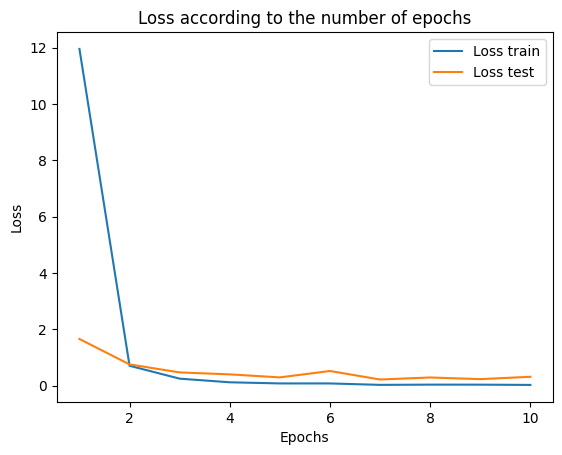

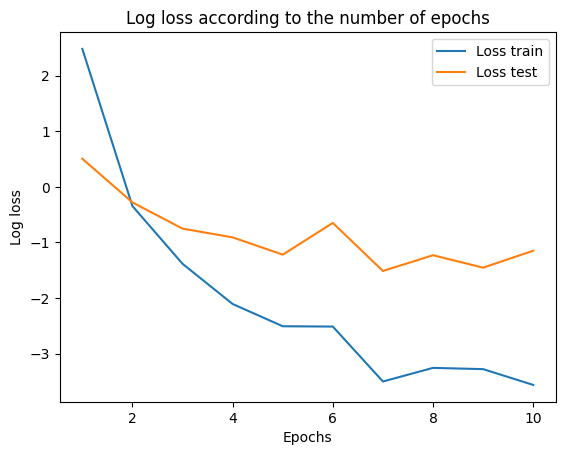

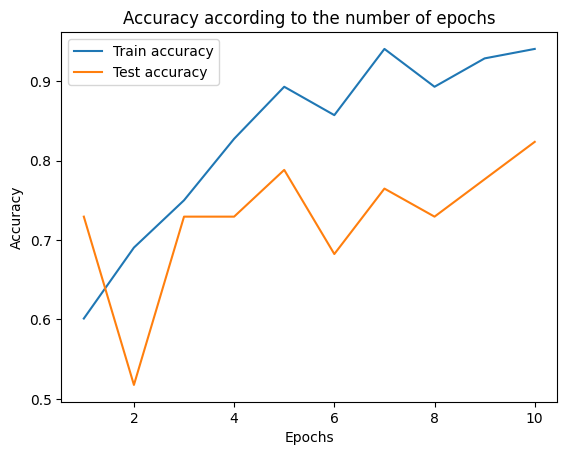

Confusion Matrix, Without Normalization


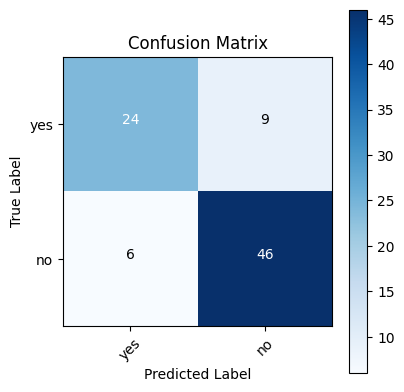

              precision    recall  f1-score   support

         yes       0.80      0.73      0.76        33
          no       0.84      0.88      0.86        52

    accuracy                           0.82        85
   macro avg       0.82      0.81      0.81        85
weighted avg       0.82      0.82      0.82        85



In [15]:
evaluation_plots(conv_class, test_loader, loss_train, acc_train, loss_test, acc_test)

## More complex network

Why: It is relatively easy to reach 100% of accuracy on the training set. We'll complexify the architecture of the network to reduce overfitting.

In [16]:
class classifier2(nn.Module):

    def __init__(self):
        super(classifier2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(in_features=1600, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=3, padding=0)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=5, padding=0)
        x = self.dropout2(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x

In [17]:
conv_class2 = classifier2()
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(conv_class2.parameters())

conv_class2.train()

loss_train, acc_train, loss_test, acc_test = train_and_test(conv_class2,train_loader, test_loader,loss_fn,optimizer_cl,n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 6.4207 Acc: 0.5476


 10%|█         | 1/10 [00:27<04:07, 27.55s/it]

Test - Loss: 0.5339 Acc: 0.6588
Train - Loss: 0.1939 Acc: 0.7024


 20%|██        | 2/10 [00:54<03:38, 27.32s/it]

Test - Loss: 0.1426 Acc: 0.6824
Train - Loss: 0.1640 Acc: 0.6548


 30%|███       | 3/10 [01:20<03:07, 26.81s/it]

Test - Loss: 0.0999 Acc: 0.7765
Train - Loss: 0.0902 Acc: 0.7262


 40%|████      | 4/10 [01:46<02:38, 26.43s/it]

Test - Loss: 0.1106 Acc: 0.6588
Train - Loss: 0.0933 Acc: 0.6726


 50%|█████     | 5/10 [02:12<02:11, 26.25s/it]

Test - Loss: 0.1166 Acc: 0.5647
Train - Loss: 0.0829 Acc: 0.7202


 60%|██████    | 6/10 [02:38<01:44, 26.01s/it]

Test - Loss: 0.0827 Acc: 0.7059
Train - Loss: 0.0874 Acc: 0.6786


 70%|███████   | 7/10 [03:03<01:17, 25.84s/it]

Test - Loss: 0.0775 Acc: 0.7412
Train - Loss: 0.0848 Acc: 0.6845


 80%|████████  | 8/10 [03:30<00:52, 26.04s/it]

Test - Loss: 0.1010 Acc: 0.6235
Train - Loss: 0.0808 Acc: 0.7262


 90%|█████████ | 9/10 [03:56<00:26, 26.15s/it]

Test - Loss: 0.0791 Acc: 0.7529
Train - Loss: 0.0750 Acc: 0.7440


100%|██████████| 10/10 [04:23<00:00, 26.32s/it]

Test - Loss: 0.1093 Acc: 0.7294


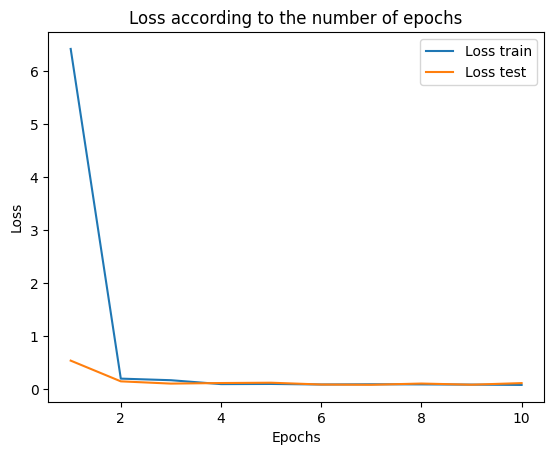

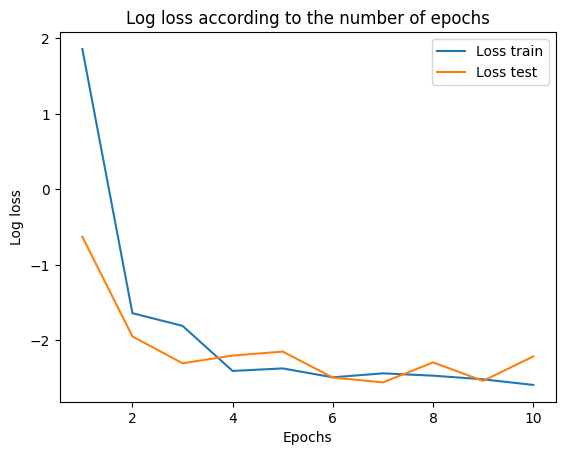

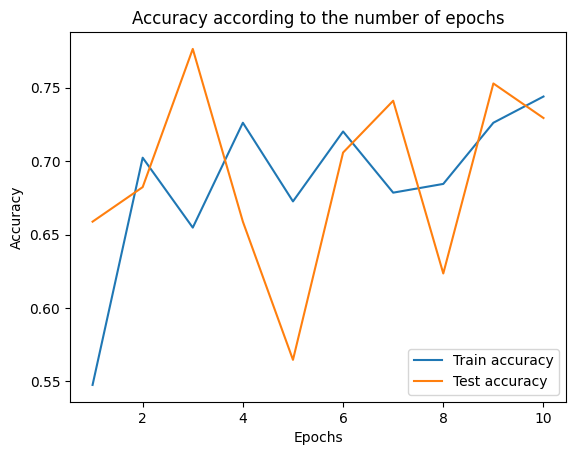

Confusion Matrix, Without Normalization


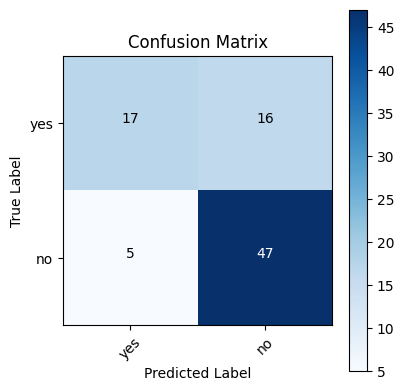

              precision    recall  f1-score   support

         yes       0.77      0.52      0.62        33
          no       0.75      0.90      0.82        52

    accuracy                           0.75        85
   macro avg       0.76      0.71      0.72        85
weighted avg       0.76      0.75      0.74        85



In [18]:
evaluation_plots(conv_class2, test_loader, loss_train, acc_train, loss_test, acc_test)

### Hyper parameters optimization

In [19]:
class classifier3(nn.Module):

    def __init__(self, nb_kernel_conv1, nb_kernel_conv2):
        super(classifier3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=nb_kernel_conv1, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(in_channels=nb_kernel_conv1, out_channels=nb_kernel_conv1*nb_kernel_conv2, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(in_features=100*nb_kernel_conv1*nb_kernel_conv2, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=3, padding=0)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=5, padding=0)
        x = self.dropout2(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x
    
    def predict(self, data_loader):
        self.eval()
        predictions = []
        labels_all = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
        
        self.train() 
        return labels_all, predictions

In [20]:
# Define the number of folds and batch size
k_folds = 3

# Count the number of iterations
iterations = 100

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Hyperparameters distribution
epochs_distrib = [5,7,10,12,15,17,20,22,25,27,30,32,35]
lr_distrib = np.linspace(1e-4, 1e-2, 19)
batch_size_distrib = [3,4,5,6,7,8,9,10,11,12]
nb_kernel_conv1_distrib = [3,4,5,6,7,8,9,10]
nb_kernel_conv2_distrib = [3,4,5,6,7,8]
params = {}
loss_train_dict = {}
acc_train_dict = {}
test_loss_dict = {}
test_acc_dict = {}

# Select randomly value from the distribution
for i in range(iterations):
    print('Iteration', i+1)
    epoch = random.choice(epochs_distrib)
    lr = random.choice(lr_distrib)
    batch_size = random.choice(batch_size_distrib)
    nb_kernel_conv1 = random.choice(nb_kernel_conv1_distrib)
    nb_kernel_conv2 = random.choice(nb_kernel_conv2_distrib)
    params[i] = (epoch, lr, batch_size, nb_kernel_conv1, nb_kernel_conv2)
    print('Epochs =', epoch)
    print('Learning rate =', lr)
    print('Batch size =', batch_size, type(batch_size))
    
    loss_train_iter = []
    acc_train_iter = []
    test_loss_iter = []
    test_acc_iter = []
    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(dsets['train'])):
        print(f"Fold {fold + 1}")
        print("-------")

        # Define the data loaders for the current fold
        train_loader_cv = torch.utils.data.DataLoader(
            dataset=dsets['train'],
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        test_loader_cv = torch.utils.data.DataLoader(
            dataset=dsets['train'],
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        conv_class3 = classifier3(nb_kernel_conv1, nb_kernel_conv2)
        loss_fn = nn.NLLLoss()
        learning_rate = lr
        optimizer_cl = torch.optim.RMSprop(conv_class3.parameters())

        # Train the model on the current fold
        loss_train, acc_train = train(conv_class3, train_loader_cv, loss_fn, optimizer_cl, epoch, verbose=False)

        loss_train_iter.append(loss_train)
        acc_train_iter.append(acc_train)
        # Evaluate the model on the test set
        conv_class3.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_cv:
                data, target = data.to(device), target.to(device)
                output = conv_class3(data)
                test_loss += nn.functional.nll_loss(output, target, reduction="sum").item()
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        test_loss_iter.append(test_loss)
        accuracy = 100.0 * correct / len(test_loader.dataset)
        test_acc_iter.append(correct / len(test_loader.dataset))

        # Print the results for the current fold
        print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
        
    loss_train_dict[i] = np.mean(loss_train_iter)
    acc_train_dict[i] = np.mean(acc_train_iter)
    test_loss_dict[i] = np.mean(test_loss_iter)
    test_acc_dict[i] = np.mean(test_acc_iter)

Iteration 1
Epochs = 5
Learning rate = 0.00175
Batch size = 3 <class 'int'>
Fold 1
-------
Test set: Average loss: 2.0942, Accuracy: 36/85 (42.35%)

Fold 2
-------
Test set: Average loss: 9.2554, Accuracy: 33/85 (38.82%)

Fold 3
-------
Test set: Average loss: 3.8127, Accuracy: 25/85 (29.41%)

Iteration 2
Epochs = 25
Learning rate = 0.01
Batch size = 5 <class 'int'>
Fold 1
-------
Test set: Average loss: 2.0354, Accuracy: 42/85 (49.41%)

Fold 2
-------
Test set: Average loss: 1.4381, Accuracy: 42/85 (49.41%)

Fold 3
-------
Test set: Average loss: 0.5504, Accuracy: 45/85 (52.94%)

Iteration 3
Epochs = 12
Learning rate = 0.0001
Batch size = 11 <class 'int'>
Fold 1
-------
Test set: Average loss: 1.4491, Accuracy: 25/85 (29.41%)

Fold 2
-------
Test set: Average loss: 0.5211, Accuracy: 41/85 (48.24%)

Fold 3
-------
Test set: Average loss: 0.2921, Accuracy: 47/85 (55.29%)

Iteration 4
Epochs = 17
Learning rate = 0.01
Batch size = 6 <class 'int'>
Fold 1
-------
Test set: Average loss: 0.3

In [21]:
max_key = max(test_acc_dict, key=test_acc_dict.get)
max_value = test_acc_dict[max_key]
best_param = params[max_key]
print('Max test accuracy:', max_value)
print('Best set of parameters:', best_param)

Max test accuracy: 0.5450980392156862
Best set of parameters: (30, 0.00725, 8, 8, 8)


In [22]:
train_loader = torch.utils.data.DataLoader(dsets['train'], batch_size=best_param[2], shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=best_param[2], shuffle=False, num_workers=2)

In [23]:
conv_class_best = classifier3(best_param[3],best_param[4])
loss_fn = nn.NLLLoss()
learning_rate = best_param[1]
optimizer_cl = torch.optim.RMSprop(conv_class_best.parameters())

conv_class_best.train()

loss_train, acc_train, loss_test, acc_test = train_and_test(conv_class_best,train_loader, test_loader,loss_fn,optimizer_cl,n_epochs = best_param[0])

  0%|          | 0/30 [00:00<?, ?it/s]

Train - Loss: 17.5581 Acc: 0.5952


  3%|▎         | 1/30 [00:39<19:14, 39.81s/it]

Test - Loss: 0.3126 Acc: 0.7412
Train - Loss: 0.2776 Acc: 0.7262


  7%|▋         | 2/30 [01:06<14:53, 31.91s/it]

Test - Loss: 0.1670 Acc: 0.7529
Train - Loss: 0.2260 Acc: 0.6964


 10%|█         | 3/30 [01:32<13:17, 29.53s/it]

Test - Loss: 0.1680 Acc: 0.7294
Train - Loss: 0.3067 Acc: 0.6905


 13%|█▎        | 4/30 [01:58<12:04, 27.88s/it]

Test - Loss: 0.2342 Acc: 0.6471
Train - Loss: 0.1851 Acc: 0.6845


 17%|█▋        | 5/30 [02:24<11:21, 27.27s/it]

Test - Loss: 0.2323 Acc: 0.5647
Train - Loss: 0.1079 Acc: 0.7262


 20%|██        | 6/30 [02:49<10:39, 26.65s/it]

Test - Loss: 0.1751 Acc: 0.5647
Train - Loss: 0.1393 Acc: 0.7083


 23%|██▎       | 7/30 [03:15<10:08, 26.48s/it]

Test - Loss: 0.1322 Acc: 0.7647
Train - Loss: 0.2958 Acc: 0.6726


 27%|██▋       | 8/30 [03:41<09:37, 26.27s/it]

Test - Loss: 0.2195 Acc: 0.6471
Train - Loss: 0.0904 Acc: 0.7976


 30%|███       | 9/30 [04:07<09:05, 25.98s/it]

Test - Loss: 0.1160 Acc: 0.7647
Train - Loss: 0.0609 Acc: 0.8393


 33%|███▎      | 10/30 [04:33<08:39, 25.97s/it]

Test - Loss: 0.1316 Acc: 0.6824
Train - Loss: 0.0860 Acc: 0.7679


 37%|███▋      | 11/30 [04:59<08:13, 25.97s/it]

Test - Loss: 0.1365 Acc: 0.6941
Train - Loss: 0.0790 Acc: 0.7917


 40%|████      | 12/30 [05:24<07:46, 25.93s/it]

Test - Loss: 0.1126 Acc: 0.6941
Train - Loss: 0.1780 Acc: 0.7381


 43%|████▎     | 13/30 [05:50<07:20, 25.94s/it]

Test - Loss: 0.3694 Acc: 0.6706
Train - Loss: 0.1077 Acc: 0.7857


 47%|████▋     | 14/30 [06:16<06:55, 25.97s/it]

Test - Loss: 0.1761 Acc: 0.7412
Train - Loss: 1.4643 Acc: 0.6667


 50%|█████     | 15/30 [06:42<06:28, 25.90s/it]

Test - Loss: 0.3022 Acc: 0.7294
Train - Loss: 0.2218 Acc: 0.7500


 53%|█████▎    | 16/30 [07:08<06:03, 25.94s/it]

Test - Loss: 0.1906 Acc: 0.8000
Train - Loss: 0.0634 Acc: 0.8869


 57%|█████▋    | 17/30 [07:34<05:35, 25.82s/it]

Test - Loss: 0.1457 Acc: 0.7647
Train - Loss: 0.0872 Acc: 0.8214


 60%|██████    | 18/30 [07:59<05:08, 25.71s/it]

Test - Loss: 0.1649 Acc: 0.7059
Train - Loss: 0.1638 Acc: 0.7917


 63%|██████▎   | 19/30 [08:25<04:42, 25.66s/it]

Test - Loss: 0.1434 Acc: 0.7647
Train - Loss: 0.0944 Acc: 0.8036


 67%|██████▋   | 20/30 [08:50<04:15, 25.58s/it]

Test - Loss: 0.1942 Acc: 0.7412
Train - Loss: 0.1540 Acc: 0.7798


 70%|███████   | 21/30 [09:16<03:50, 25.64s/it]

Test - Loss: 0.1964 Acc: 0.7059
Train - Loss: 0.0782 Acc: 0.8214


 73%|███████▎  | 22/30 [09:42<03:26, 25.80s/it]

Test - Loss: 0.1575 Acc: 0.7647
Train - Loss: 0.0611 Acc: 0.8452


 77%|███████▋  | 23/30 [10:08<03:00, 25.83s/it]

Test - Loss: 0.1334 Acc: 0.7882
Train - Loss: 0.0638 Acc: 0.8631


 80%|████████  | 24/30 [10:33<02:34, 25.67s/it]

Test - Loss: 0.1573 Acc: 0.7529
Train - Loss: 0.1383 Acc: 0.7857


 83%|████████▎ | 25/30 [10:59<02:07, 25.59s/it]

Test - Loss: 0.4753 Acc: 0.5882
Train - Loss: 2.3300 Acc: 0.6786


 87%|████████▋ | 26/30 [11:24<01:42, 25.52s/it]

Test - Loss: 19.5026 Acc: 0.3882
Train - Loss: 3.7497 Acc: 0.6964


 90%|█████████ | 27/30 [11:49<01:16, 25.44s/it]

Test - Loss: 0.3557 Acc: 0.7294
Train - Loss: 0.2664 Acc: 0.7917


 93%|█████████▎| 28/30 [12:15<00:50, 25.44s/it]

Test - Loss: 0.4008 Acc: 0.8235
Train - Loss: 0.1609 Acc: 0.8274


 97%|█████████▋| 29/30 [12:40<00:25, 25.38s/it]

Test - Loss: 0.1857 Acc: 0.8235
Train - Loss: 0.0990 Acc: 0.8571


100%|██████████| 30/30 [13:06<00:00, 26.21s/it]

Test - Loss: 0.2889 Acc: 0.7647


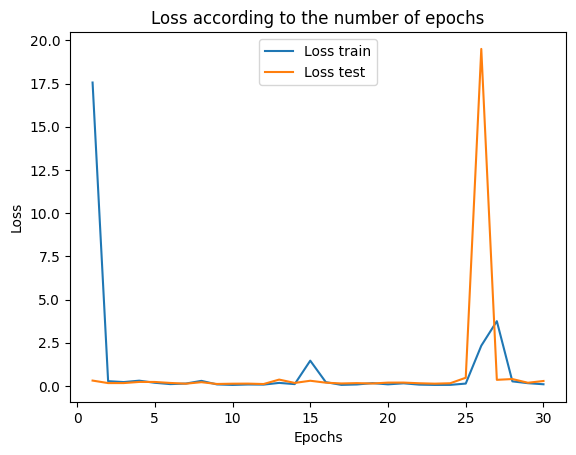

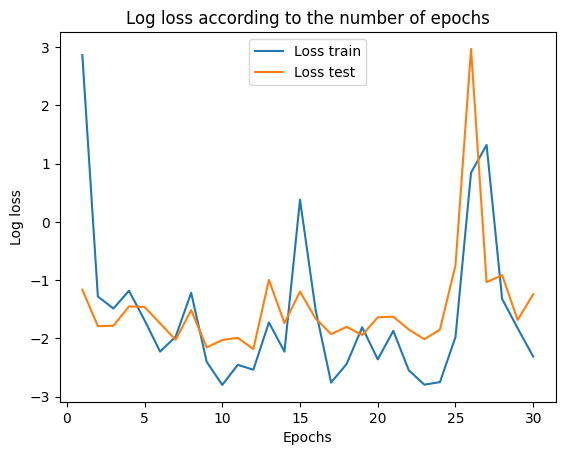

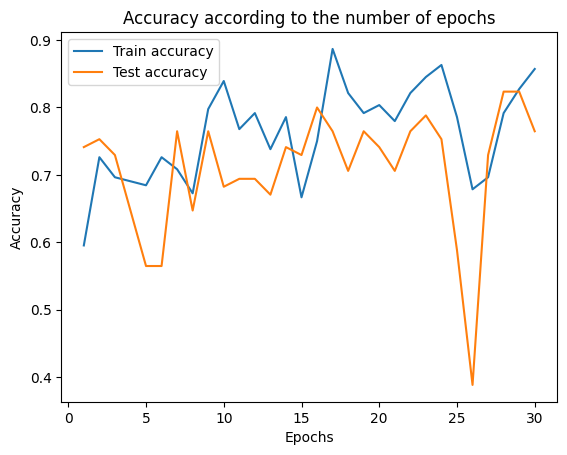

Confusion Matrix, Without Normalization


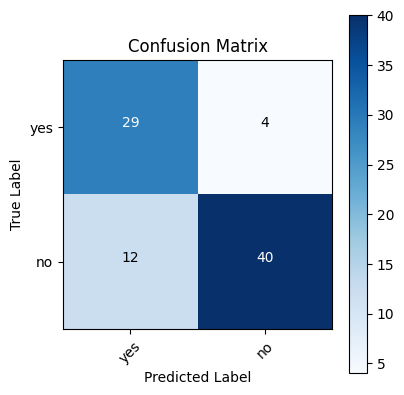

              precision    recall  f1-score   support

         yes       0.71      0.88      0.78        33
          no       0.91      0.77      0.83        52

    accuracy                           0.81        85
   macro avg       0.81      0.82      0.81        85
weighted avg       0.83      0.81      0.81        85



In [24]:
evaluation_plots(conv_class_best, test_loader, loss_train, acc_train, loss_test, acc_test)

### Optimization of the first simple classifier

In [25]:
class classifier_simple2(nn.Module):

    def __init__(self):
        super(classifier_simple2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc = nn.Linear(in_features=11552, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=4, padding=1)
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x
    
    def predict(self, data_loader):
        self.eval()
        predictions = []
        labels_all = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
        
        self.train() 
        return labels_all, predictions

In [26]:
conv_class = classifier_simple2()
conv_class.train()
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(conv_class.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(conv_class,train_loader, test_loader,loss_fn,optimizer_cl,n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 1.1792 Acc: 0.5774


 10%|█         | 1/10 [00:25<03:51, 25.73s/it]

Test - Loss: 0.0761 Acc: 0.6471
Train - Loss: 0.0736 Acc: 0.6964


 20%|██        | 2/10 [00:51<03:24, 25.52s/it]

Test - Loss: 0.0731 Acc: 0.7176
Train - Loss: 0.0702 Acc: 0.7619


 30%|███       | 3/10 [18:53<59:17, 508.20s/it]

Test - Loss: 0.0749 Acc: 0.6941
Train - Loss: 0.0671 Acc: 0.7857


 40%|████      | 4/10 [19:19<31:47, 317.88s/it]

Test - Loss: 0.0709 Acc: 0.7294
Train - Loss: 0.0648 Acc: 0.8036


 50%|█████     | 5/10 [20:35<19:13, 230.61s/it]

Test - Loss: 0.0737 Acc: 0.6941
Train - Loss: 0.0576 Acc: 0.7738


 60%|██████    | 6/10 [21:59<12:02, 180.65s/it]

Test - Loss: 0.0762 Acc: 0.7176
Train - Loss: 0.0537 Acc: 0.8274


 70%|███████   | 7/10 [22:24<06:29, 129.83s/it]

Test - Loss: 0.0739 Acc: 0.7412
Train - Loss: 0.0453 Acc: 0.8452


 80%|████████  | 8/10 [22:49<03:13, 96.51s/it] 

Test - Loss: 0.0780 Acc: 0.7765
Train - Loss: 0.0523 Acc: 0.8333


 90%|█████████ | 9/10 [23:14<01:14, 74.20s/it]

Test - Loss: 0.0722 Acc: 0.7765
Train - Loss: 0.0423 Acc: 0.8631


100%|██████████| 10/10 [23:40<00:00, 142.01s/it]

Test - Loss: 0.0959 Acc: 0.7647


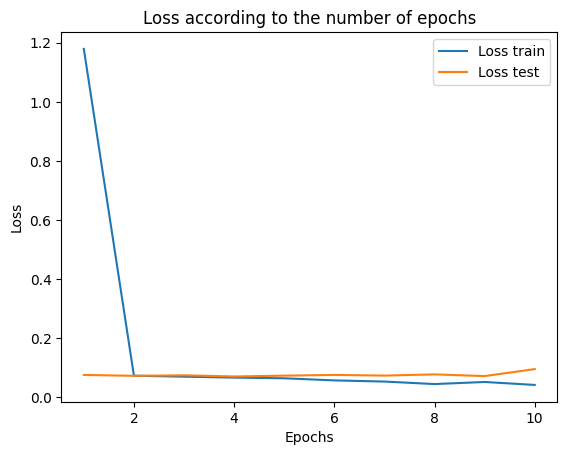

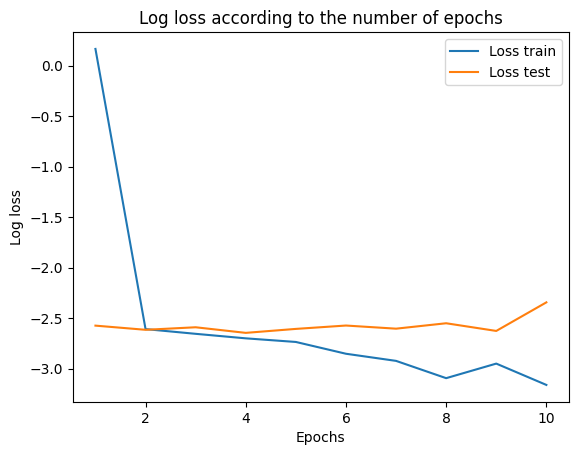

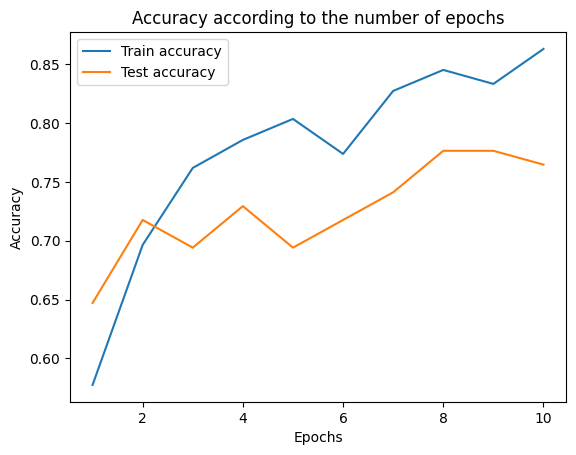

Confusion Matrix, Without Normalization


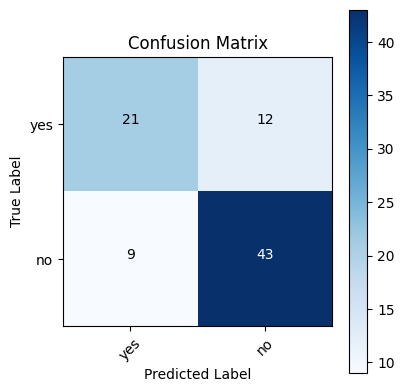

              precision    recall  f1-score   support

         yes       0.70      0.64      0.67        33
          no       0.78      0.83      0.80        52

    accuracy                           0.75        85
   macro avg       0.74      0.73      0.74        85
weighted avg       0.75      0.75      0.75        85



In [27]:
evaluation_plots(conv_class, test_loader, loss_train, acc_train, loss_test, acc_test)

## Hyperparameter optimization of the first classifier with one convolutional layer

In [28]:
class classifier_simple_hp(nn.Module):

    def __init__(self, nb_kernel_conv, kernel_size_conv, kernel_size_maxpool):
        super(classifier_simple_hp, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=nb_kernel_conv, kernel_size=kernel_size_conv, padding=int((kernel_size_conv-1)/2))
        self.fc = nn.Linear(in_features=int(nb_kernel_conv*(((150 + int(150 % kernel_size_maxpool))/kernel_size_maxpool))**2), out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=kernel_size_maxpool, padding=int((150 % kernel_size_maxpool)/2))
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x
    
    def predict(self, data_loader):
        self.eval()
        predictions = []
        labels_all = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
        
        self.train() 
        return labels_all, predictions

In [29]:
# Define the number of folds and batch size
k_folds = 3

# Count the number of iterations
iterations = 100

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Hyperparameters distribution
epochs_distrib = [5,7,10,12,15,17,20,22,25,27,30,32,35]
lr_distrib = np.linspace(1e-4, 1e-2, 19)
batch_size_distrib = [3,4,5,6,7,8,9,10,11,12]
nb_kernel_conv_distrib = [3,4,5,6,7,8,9,10]
kernel_size_conv_distrib = [1,3,5,7]
kernel_size_maxpool_distrib = [2,4,6]

params = {}
loss_train_dict = {}
acc_train_dict = {}
test_loss_dict = {}
test_acc_dict = {}

# Select randomly value from the distribution
for i in range(iterations):
    print('Iteration', i+1)
    epoch = random.choice(epochs_distrib)
    lr = random.choice(lr_distrib)
    batch_size = random.choice(batch_size_distrib)
    nb_kernel_conv = random.choice(nb_kernel_conv_distrib)
    kernel_size_conv = random.choice(kernel_size_conv_distrib)
    kernel_size_maxpool = random.choice(kernel_size_maxpool_distrib)
    params[i] = (epoch, lr, batch_size, nb_kernel_conv, kernel_size_conv, kernel_size_maxpool)
    print('Epochs =', epoch)
    print('Learning rate =', lr)
    print('Batch size =', batch_size)
    print('Number of kernels for the conv layer =', nb_kernel_conv)
    print('Size of the kernels for the conv layer =', kernel_size_conv)
    print('Size of the kernel for the max pool layer =', kernel_size_maxpool)
    
    loss_train_iter = []
    acc_train_iter = []
    test_loss_iter = []
    test_acc_iter = []
    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(dsets['train'])):
        print(f"Fold {fold + 1}")
        print("-------")

        # Define the data loaders for the current fold
        train_loader_cv = torch.utils.data.DataLoader(
            dataset=dsets['train'],
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        test_loader_cv = torch.utils.data.DataLoader(
            dataset=dsets['train'],
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        conv_class = classifier_simple_hp(nb_kernel_conv, kernel_size_conv, kernel_size_maxpool)
        loss_fn = nn.NLLLoss()
        learning_rate = lr
        optimizer_cl = torch.optim.RMSprop(conv_class.parameters())

        # Train the model on the current fold
        loss_train, acc_train = train(conv_class, train_loader_cv, loss_fn, optimizer_cl, epoch, verbose=False)

        loss_train_iter.append(loss_train)
        acc_train_iter.append(acc_train)
        # Evaluate the model on the test set
        conv_class.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_cv:
                data, target = data.to(device), target.to(device)
                output = conv_class(data)
                test_loss += nn.functional.nll_loss(output, target, reduction="sum").item()
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        test_loss_iter.append(test_loss)
        accuracy = 100.0 * correct / len(test_loader.dataset)
        test_acc_iter.append(correct / len(test_loader.dataset))

        # Print the results for the current fold
        print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
        
    loss_train_dict[i] = np.mean(loss_train_iter)
    acc_train_dict[i] = np.mean(acc_train_iter)
    test_loss_dict[i] = np.mean(test_loss_iter)
    test_acc_dict[i] = np.mean(test_acc_iter)

Iteration 1
Epochs = 30
Learning rate = 0.00725
Batch size = 4
Number of kernels for the conv layer = 4
Size of the kernels for the conv layer = 1
Size of the kernel for the max pool layer = 4
Fold 1
-------
Test set: Average loss: 0.7785, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 0.6391, Accuracy: 45/85 (52.94%)

Fold 3
-------
Test set: Average loss: 1.0349, Accuracy: 46/85 (54.12%)

Iteration 2
Epochs = 27
Learning rate = 0.00395
Batch size = 3
Number of kernels for the conv layer = 5
Size of the kernels for the conv layer = 5
Size of the kernel for the max pool layer = 2
Fold 1
-------
Test set: Average loss: 4.6524, Accuracy: 44/85 (51.76%)

Fold 2
-------
Test set: Average loss: 5.5882, Accuracy: 44/85 (51.76%)

Fold 3
-------
Test set: Average loss: 2.3662, Accuracy: 44/85 (51.76%)

Iteration 3
Epochs = 5
Learning rate = 0.0089
Batch size = 7
Number of kernels for the conv layer = 4
Size of the kernels for the conv layer = 5
Size of the kernel for the max 

In [30]:
# params[i] = (epoch, lr, batch_size, nb_kernel_conv, kernel_size_conv, kernel_size_maxpool)

In [31]:
import joblib

joblib.dump(params, 'params_hyperparam_optim_1conv.joblib')
joblib.dump(test_acc_dict, 'test_acc_hyperparam_optim_1conv.joblib')

['test_acc_hyperparam_optim_1conv.joblib']

In [32]:
max_key = max(test_acc_dict, key=test_acc_dict.get)
max_value = test_acc_dict[max_key]
best_param2 = params[max_key]
print('Max test accuracy:', max_value)
print('Best set of parameters:', best_param2)
print('Iteration nb', max_key)

Max test accuracy: 0.5607843137254903
Best set of parameters: (35, 0.00285, 11, 6, 3, 4)
Iteration nb 98


In [33]:
train_loader = torch.utils.data.DataLoader(dsets['train'], batch_size=best_param2[2], shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=best_param2[2], shuffle=False, num_workers=2)

In [34]:
class classifier_simple_best(nn.Module):

    def __init__(self):
        super(classifier_simple_best, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=best_param2[3], kernel_size=best_param2[4], padding=int((best_param2[4]-1)/2))
        self.fc = nn.Linear(in_features=int(best_param2[3]*(((150 + (150 % best_param2[5]))/best_param2[5]))**2), out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=best_param2[5], padding=int((150 % best_param2[5])/2))
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x
    
    def predict(self, data_loader):
        self.eval()
        predictions = []
        labels_all = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
        
        self.train() 
        return labels_all, predictions

In [35]:
conv_class_best2 = classifier_simple_best()
loss_fn = nn.NLLLoss()
learning_rate = best_param[1]
optimizer_cl = torch.optim.RMSprop(conv_class_best2.parameters())

conv_class_best2.train()

loss_train, acc_train, loss_test, acc_test = train_and_test(conv_class_best2,train_loader, test_loader,loss_fn,optimizer_cl,n_epochs = best_param[0])

  0%|          | 0/30 [00:00<?, ?it/s]

Train - Loss: 5.5851 Acc: 0.6071


  3%|▎         | 1/30 [00:26<12:46, 26.42s/it]

Test - Loss: 0.2053 Acc: 0.7647
Train - Loss: 0.1883 Acc: 0.7321


  7%|▋         | 2/30 [00:51<12:04, 25.88s/it]

Test - Loss: 0.0852 Acc: 0.6941
Train - Loss: 0.0798 Acc: 0.7798


 10%|█         | 3/30 [01:17<11:35, 25.77s/it]

Test - Loss: 0.1061 Acc: 0.7294
Train - Loss: 0.0697 Acc: 0.8155


 13%|█▎        | 4/30 [01:43<11:14, 25.94s/it]

Test - Loss: 0.0838 Acc: 0.6824
Train - Loss: 0.0425 Acc: 0.8214


 17%|█▋        | 5/30 [02:10<10:57, 26.31s/it]

Test - Loss: 0.0619 Acc: 0.8235
Train - Loss: 0.0221 Acc: 0.8869


 20%|██        | 6/30 [02:37<10:32, 26.34s/it]

Test - Loss: 0.0569 Acc: 0.8118
Train - Loss: 0.0158 Acc: 0.9226


 23%|██▎       | 7/30 [03:03<10:05, 26.33s/it]

Test - Loss: 0.0573 Acc: 0.7765
Train - Loss: 0.0071 Acc: 0.9821


 27%|██▋       | 8/30 [03:29<09:34, 26.11s/it]

Test - Loss: 0.0579 Acc: 0.8000
Train - Loss: 0.0113 Acc: 0.9524


 30%|███       | 9/30 [03:54<09:06, 26.05s/it]

Test - Loss: 0.2706 Acc: 0.6000
Train - Loss: 0.0398 Acc: 0.8929


 33%|███▎      | 10/30 [04:20<08:40, 26.00s/it]

Test - Loss: 0.0698 Acc: 0.8353
Train - Loss: 0.0032 Acc: 0.9940


 37%|███▋      | 11/30 [04:47<08:16, 26.13s/it]

Test - Loss: 0.0646 Acc: 0.8000
Train - Loss: 0.0034 Acc: 0.9940


 40%|████      | 12/30 [05:13<07:49, 26.09s/it]

Test - Loss: 0.0638 Acc: 0.8235
Train - Loss: 0.0018 Acc: 1.0000


 43%|████▎     | 13/30 [05:39<07:24, 26.16s/it]

Test - Loss: 0.0663 Acc: 0.8000
Train - Loss: 0.0014 Acc: 1.0000


 47%|████▋     | 14/30 [06:06<07:00, 26.25s/it]

Test - Loss: 0.0663 Acc: 0.8000
Train - Loss: 0.0013 Acc: 1.0000


 50%|█████     | 15/30 [06:32<06:33, 26.23s/it]

Test - Loss: 0.0670 Acc: 0.8235
Train - Loss: 0.0012 Acc: 1.0000


 53%|█████▎    | 16/30 [06:58<06:09, 26.36s/it]

Test - Loss: 0.0684 Acc: 0.8353
Train - Loss: 0.0010 Acc: 1.0000


 57%|█████▋    | 17/30 [07:25<05:42, 26.37s/it]

Test - Loss: 0.0692 Acc: 0.8353
Train - Loss: 0.0008 Acc: 1.0000


 60%|██████    | 18/30 [07:51<05:16, 26.38s/it]

Test - Loss: 0.0690 Acc: 0.8235
Train - Loss: 0.0008 Acc: 1.0000


 63%|██████▎   | 19/30 [08:17<04:48, 26.26s/it]

Test - Loss: 0.0731 Acc: 0.8000
Train - Loss: 0.0008 Acc: 1.0000


 67%|██████▋   | 20/30 [08:44<04:23, 26.37s/it]

Test - Loss: 0.0716 Acc: 0.8235
Train - Loss: 0.0006 Acc: 1.0000


 70%|███████   | 21/30 [09:10<03:57, 26.35s/it]

Test - Loss: 0.0719 Acc: 0.8118
Train - Loss: 0.0006 Acc: 1.0000


 73%|███████▎  | 22/30 [09:37<03:31, 26.41s/it]

Test - Loss: 0.0750 Acc: 0.8000
Train - Loss: 0.0005 Acc: 1.0000


 77%|███████▋  | 23/30 [10:03<03:04, 26.38s/it]

Test - Loss: 0.0750 Acc: 0.8000
Train - Loss: 0.0005 Acc: 1.0000


 80%|████████  | 24/30 [10:30<02:39, 26.63s/it]

Test - Loss: 0.0760 Acc: 0.8000
Train - Loss: 0.0005 Acc: 1.0000


 83%|████████▎ | 25/30 [10:56<02:11, 26.39s/it]

Test - Loss: 0.0775 Acc: 0.8471
Train - Loss: 0.0004 Acc: 1.0000


 87%|████████▋ | 26/30 [11:22<01:44, 26.17s/it]

Test - Loss: 0.0785 Acc: 0.8000
Train - Loss: 0.0004 Acc: 1.0000


 90%|█████████ | 27/30 [11:48<01:18, 26.13s/it]

Test - Loss: 0.0781 Acc: 0.8353
Train - Loss: 0.0003 Acc: 1.0000


 93%|█████████▎| 28/30 [12:14<00:52, 26.20s/it]

Test - Loss: 0.0770 Acc: 0.8353
Train - Loss: 0.0003 Acc: 1.0000


 97%|█████████▋| 29/30 [12:40<00:26, 26.17s/it]

Test - Loss: 0.0773 Acc: 0.8235
Train - Loss: 0.0002 Acc: 1.0000


100%|██████████| 30/30 [13:07<00:00, 26.24s/it]

Test - Loss: 0.0790 Acc: 0.8235


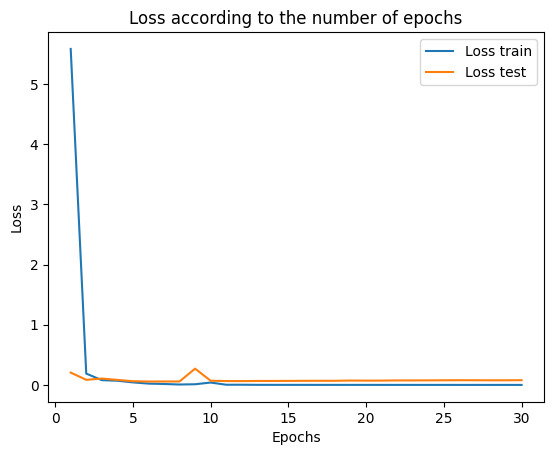

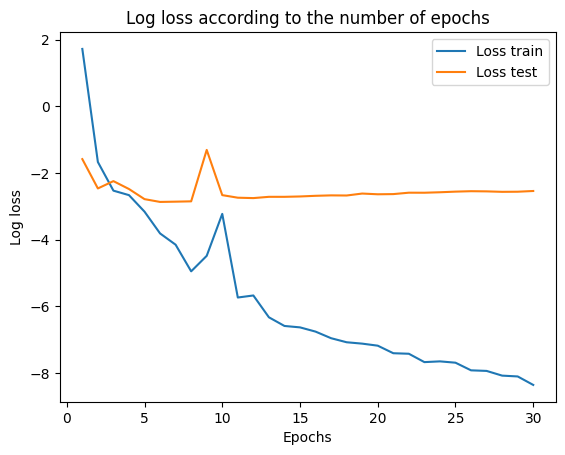

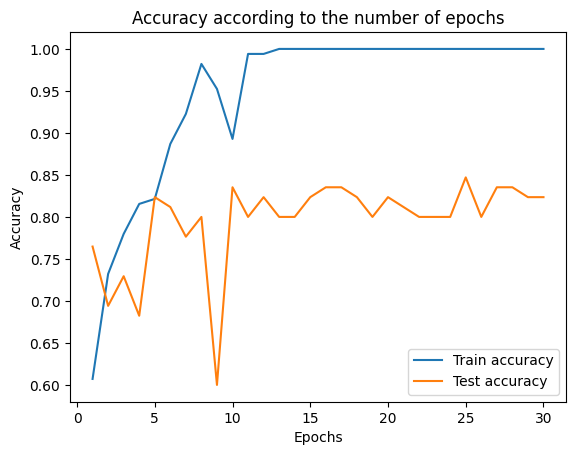

Confusion Matrix, Without Normalization


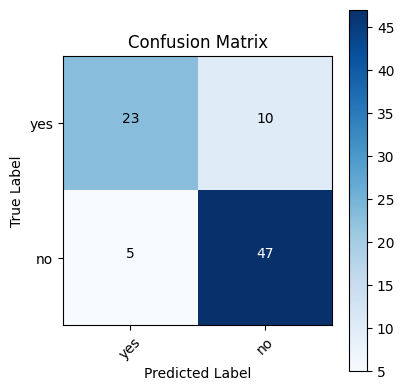

              precision    recall  f1-score   support

         yes       0.82      0.70      0.75        33
          no       0.82      0.90      0.86        52

    accuracy                           0.82        85
   macro avg       0.82      0.80      0.81        85
weighted avg       0.82      0.82      0.82        85



In [36]:
evaluation_plots(conv_class_best2, test_loader, loss_train, acc_train, loss_test, acc_test)

In [41]:
classifier = classifier().to(device)
classifier2 = classifier2().to(device)
classifier3 = classifier3(6,8).to(device)
classifier_simple2 = classifier_simple2().to(device)
classifier_simple_best = classifier_simple_best().to(device)

In [42]:
results = {'Accuracy':[accuracy_score(predict(classifier, test_loader)[0],predict(classifier, test_loader)[1]),
                       accuracy_score(predict(classifier2, test_loader)[0],predict(classifier2, test_loader)[1]),
                       accuracy_score(predict(classifier3, test_loader)[0],predict(classifier3, test_loader)[1]),
                       accuracy_score(predict(classifier_simple2, test_loader)[0],predict(classifier_simple2, test_loader)[1]),
                       accuracy_score(predict(classifier_simple_best, test_loader)[0],predict(classifier_simple_best, test_loader)[1])],
           
           'Precision':[precision_score(predict(classifier, test_loader)[0],predict(classifier, test_loader)[1]),
                       precision_score(predict(classifier2, test_loader)[0],predict(classifier2, test_loader)[1]),
                       precision_score(predict(classifier3, test_loader)[0],predict(classifier3, test_loader)[1]),
                       precision_score(predict(classifier_simple2, test_loader)[0],predict(classifier_simple2, test_loader)[1]),
                       precision_score(predict(classifier_simple_best, test_loader)[0],predict(classifier_simple_best, test_loader)[1])],
           
           'Recall':[recall_score(predict(classifier, test_loader)[0],predict(classifier, test_loader)[1]),
                     recall_score(predict(classifier2, test_loader)[0],predict(classifier2, test_loader)[1]),
                     recall_score(predict(classifier3, test_loader)[0],predict(classifier3, test_loader)[1]),
                     recall_score(predict(classifier_simple2, test_loader)[0],predict(classifier_simple2, test_loader)[1]),
                       precision_score(predict(classifier_simple_best, test_loader)[0],predict(classifier_simple_best, test_loader)[1])],
           
           'F1-score':[f1_score(predict(classifier, test_loader)[0],predict(classifier, test_loader)[1]),
                     f1_score(predict(classifier2, test_loader)[0],predict(classifier2, test_loader)[1]),
                     f1_score(predict(classifier3, test_loader)[0],predict(classifier3, test_loader)[1]),
                     f1_score(predict(classifier_simple2, test_loader)[0],predict(classifier_simple2, test_loader)[1]),
                     f1_score(predict(classifier_simple_best, test_loader)[0],predict(classifier_simple_best, test_loader)[1])]}

class_results = pd.DataFrame(results, index=['Classifier 1 conv', 'Classifier 2 conv', 'Classifier 2 conv optimized', 
                                             'Classifier 1 conv + dropout', 'Classifier 1 conv optimized'])

In [43]:
class_results

,Accuracy,Precision,Recall,F1-score
Classifier 1 conv,0.564706,0.647059,0.634615,0.640777
Classifier 2 conv,0.623529,0.619048,1.000000,0.764706
Classifier 2 conv optimized,0.611765,0.611765,1.000000,0.759124
Classifier 1 conv + dropout,0.658824,0.701754,0.769231,0.733945
Classifier 1 conv optimized,0.611765,0.611765,0.611765,0.759124
